In [117]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import os
from scipy.optimize import dual_annealing

In [38]:
# Load the data
DATA_PATH = '../data/'
all_data = pkl.load(open(os.path.join(DATA_PATH, 'all_data.pkl'), 'rb'))
for patient_id in all_data.keys():
    all_data[patient_id]['data'] = all_data[patient_id]['data'].drop([index for index in all_data[patient_id]['data'].index if 'REPLAN' in index or 'RT' in index or 'PT' in index])

patient_001_data = all_data['001']['data']
patient_001_label = all_data['001']['label']

In [55]:
def feature_extraction(volume_diff, model_index='1'):
    assert len(volume_diff) >= 5, "Volume difference must have more than 5 measurements"
    # Extract the mean over the last two measurements
    feature1 = np.mean(volume_diff[-2:], axis=0)

    # Calculate a linear regression over the data
    x = np.arange(len(volume_diff))
    y = volume_diff
    A = np.vstack([x, np.ones(len(x))]).T
    feature2, c = np.linalg.lstsq(A, y, rcond=None)[0]

    # Calculate a linear regression over the last 5 measurements
    x = np.arange(len(volume_diff) - 5, len(volume_diff))
    y = volume_diff[-5:]
    A = np.vstack([x, np.ones(len(x))]).T
    feature3, c = np.linalg.lstsq(A, y, rcond=None)[0]

    if model_index == '1':
        return [feature1, feature2, feature3]
    elif model_index == '2':
        return [feature1, feature3]
    elif model_index == '3':
        return [feature1, feature2]
    elif model_index == '4':
        return [feature1]

    return 
        

In [149]:
def loss_function(true_replan_fraction, estimated_replan_fraction, late_pun=0.8, false_negative=900, false_positive=300):
    if (true_replan_fraction != 0 and estimated_replan_fraction == 0):
        return late_pun*(33 - true_replan_fraction)**2 + false_negative # Punish for the remaining fractions
    elif (true_replan_fraction == 0 and estimated_replan_fraction != 0):
        return late_pun*(estimated_replan_fraction) + false_positive # Punish for the remaining fractions
    elif estimated_replan_fraction > true_replan_fraction:
        return late_pun * (estimated_replan_fraction - true_replan_fraction)**2
    elif estimated_replan_fraction <= true_replan_fraction:
        return (1 - late_pun) * (true_replan_fraction - estimated_replan_fraction)**2
    else:
        print('Error in loss function')
    


def model(all_data, thresholds, model_index='1', p_late_pun=0.8, p_false_negative=900, p_false_positive=300, f1_score=False):
    overall_loss = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for key in all_data.keys():
        # print(f'analyzing patient {key}')
        data = all_data[key]['data']['volume difference to pCT [%]'].to_numpy()
        label = all_data[key]['label'][0]
        estim_replan_fraction = 0
        
        for i in range(5, len(data) + 1):
            # Extract the features
            features = feature_extraction(data[:i], model_index=model_index)
            
            if (features < thresholds).all():
                # print(f'patient {key} exceeded the threshold at {i} measurements')
                estim_replan_fraction = i
                break

    
        overall_loss += [loss_function(label, estim_replan_fraction, p_late_pun, p_false_negative, p_false_positive)]
        if label > 0 and estim_replan_fraction > 0:
            tp += 1
        elif label == 0 and estim_replan_fraction == 0:
            tn += 1
        elif label > 0 and estim_replan_fraction == 0:
            fp += 1
        elif label == 0 and estim_replan_fraction > 0:
            fn += 1
        
    
    # Calculate the overall loss and f1 score
    overall_loss = np.mean(overall_loss)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if f1_score:
        return f1
    # print(f'Overall loss: {overall_loss}')
    return overall_loss

# model(all_data, [0.5, 0.5, 0.5], model_index='1')
model(all_data, [-3.02068759], model_index='4', f1_score=True)

0.9285714285714286

In [121]:
result = dual_annealing(lambda x: model(all_data, x, '4'), bounds=[(-4, -1)], maxiter=1000)
print(result.x)
print(result.fun)

[-2.01708158]
40.86666666666666


In [90]:
from skopt import gp_minimize
from skopt.space import Real

def objective(thresholds):
    thresholds = np.array(thresholds)
    return model(all_data, thresholds, model_index='3')

res = gp_minimize(
    objective,
    dimensions=[Real(-4, -1), Real(-1.5, 0)],  # Adjust ranges based on expected threshold space
    n_calls=100,
    random_state=0
)

print("Best loss:", res.fun)
print("Best thresholds:", res.x)


Best loss: 31.476190476190474
Best thresholds: [-2.895275380478356, -0.06426726157043006]


In [110]:
# LOOCV
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Example data
X = np.array([key for key in all_data.keys()]).reshape(-1, 1)
y = np.array([all_data[key]['label'][0] for key in all_data.keys()]).reshape(-1, 1)

loo = LeaveOneOut()
threshold_list = []
error_list = []
for train_index, test_index in loo.split(X):
    print(test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # print(X_train, X_test, y_train, y_test)
    train_data = {key: all_data[key] for key in X_train.flatten()}
    test_data = {key: all_data[key] for key in X_test.flatten()}
    
    # Learn threshold
    opt_threshold = dual_annealing(lambda x: model(train_data, x, '4'), bounds=[(-4, -1)], maxiter=1000).x
    threshold_list.append(opt_threshold)

    error = model(test_data, opt_threshold, '4')
    error_list.append(error)

    
#     model = LogisticRegression()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     accuracies.append(accuracy_score(y_test, y_pred))

# print("Mean LOOCV accuracy:", np.mean(accuracies))



[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]


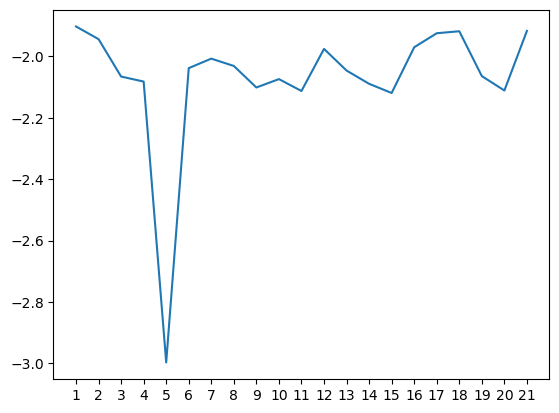

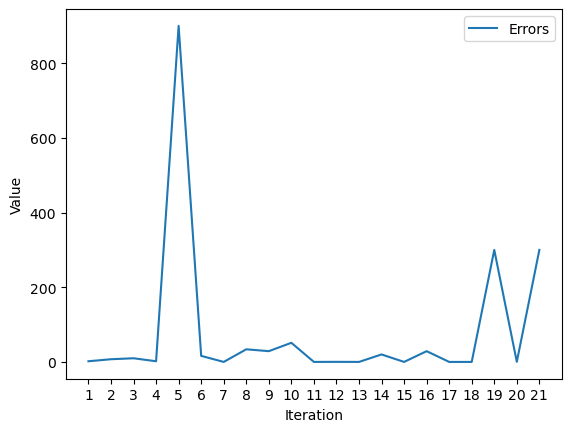

In [116]:
plt.plot(threshold_list, label='Thresholds')
plt.xticks(range(len(threshold_list)), [f'{i+1}' for i in range(len(threshold_list))])
plt.show()
plt.plot(error_list, label='Errors')
plt.xticks(range(len(threshold_list)), [f'{i+1}' for i in range(len(threshold_list))])
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

In [151]:
from itertools import product
# Define Hyperparameters
p_late_pun = [0.5, 0.6, 0.7, 0.8, 0.9]
fp = [25, 100, 300, 500, 800, 1000]
fn = [25, 100, 300, 500, 800, 1000]
p_late_pun = [0.5, 0.9]
fp = [25, 800]
fn = [25, 800]

# Define the parameter grid
grid = list(product(p_late_pun, fp, fn))

# LOOCV
from sklearn.model_selection import LeaveOneOut
import numpy as np

# All data
X = np.array([key for key in all_data.keys()]).reshape(-1, 1)
y = np.array([all_data[key]['label'][0] for key in all_data.keys()]).reshape(-1, 1)

error_matrix = np.zeros((5, 4)) # 5 Test sets, 4 Models
f1_matrix = np.zeros((5, 4)) # 5 Test sets, 4 Models
# Sample a random test set X times
for m in range(5):
    # Out of patients with y not 0, randomly sample 4 patients, and those with y=0, randomly sample 2 patients
    test_index_replan =  np.random.choice(np.where(y.flatten() != 0)[0], size=4, replace=False)
    test_index_no_replan = np.random.choice(np.where(y.flatten() == 0)[0], size=2, replace=False)
    test_index = np.concatenate((test_index_replan, test_index_no_replan))

    # Prepare the test and train data
    X_test = X[test_index]
    y_test = y[test_index]
    X_ = np.delete(X, test_index, axis=0)
    y_ = np.delete(y, test_index, axis=0)

    print(f'Patient IDs in test set: {X_test.flatten()}')
    print(f'Patient IDs in train set: {X_.flatten()}')

   
    # Iterate through all hyperparameter combinations
    for i, (p_late_pun, fp, fn) in enumerate(grid):

        loo = LeaveOneOut()
        threshold_list = []
        loocv_error_matrix = np.zeros((len(grid), len(X_)))
        loocv_f1_matrix = np.zeros((len(grid), len(X_)))
        for n, (train_index, val_index) in enumerate(loo.split(X_)):
            print(f'Patient in evaluation set: {X_[val_index]}')
            X_train, X_val = X_[train_index], X_[val_index]
            # y_train, y_val = y_[train_index], y_[val_index]
 
            
            train_data = {key: all_data[key] for key in X_train.flatten()}
            val_data = {key: all_data[key] for key in X_val.flatten()}
            
            # Learn threshold
            opt_threshold = dual_annealing(lambda x: model(train_data, x, '4'), bounds=[(-4, -1)], maxiter=1000).x
            threshold_list.append(opt_threshold)

            error = model(test_data, opt_threshold, '4')
            error_list.append(error)
            loocv_error_matrix[i, n] = error

            # Calculate f1-score
            f1 = model(val_data, opt_threshold, '4', f1_score=True)
            loocv_f1_matrix[i, n] = f1
            
        # Calculate the mean error for this hyperparameter combination
        mean_error = np.mean(loocv_error_matrix[i, :])
        error_matrix[m, i] = mean_error
        mean_f1 = np.mean(loocv_f1_matrix[i, :])
        f1_matrix[m, i] = mean_f1
        print(threshold_list)

        # break # Only one hyperparameter combination for now



Patient IDs in test set: ['007' '004' '010' '002' '019' '021']
Patient IDs in train set: ['001' '003' '005' '006' '008' '009' '011' '012' '013' '014' '015' '016'
 '017' '018' '020']
Patient in evaluation set: [['001']]
Patient in evaluation set: [['003']]
Patient in evaluation set: [['005']]
Patient in evaluation set: [['006']]
Patient in evaluation set: [['008']]
Patient in evaluation set: [['009']]
Patient in evaluation set: [['011']]
Patient in evaluation set: [['012']]
Patient in evaluation set: [['013']]
Patient in evaluation set: [['014']]
Patient in evaluation set: [['015']]
Patient in evaluation set: [['016']]
Patient in evaluation set: [['017']]
Patient in evaluation set: [['018']]
Patient in evaluation set: [['020']]
[array([-1.95922997]), array([-1.96587077]), array([-3.90892799]), array([-2.00900267]), array([-1.95754751]), array([-2.11611921]), array([-2.05447973]), array([-2.01771506]), array([-2.01270871]), array([-2.08962154]), array([-1.91470979]), array([-2.05625248])

KeyboardInterrupt: 

In [150]:
error_matrix

array([[306.93333333,   0.        ,   0.        ,   0.        ],
       [314.4       ,   0.        ,   0.        ,   0.        ],
       [306.93333333,   0.        ,   0.        ,   0.        ],
       [306.4       ,   0.        ,   0.        ,   0.        ],
       [307.68      ,   0.        ,   0.        ,   0.        ]])